In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [4]:
import torch
import os
from CIA.getters import get_handler, get_data_processor, \
    get_dataloader_generator, get_decoder, get_positional_embedding,\
    get_sos_embedding
# from CIA.handlers.decoder_events_handler import 
import time
import importlib
from CIA.positional_embeddings.positional_embedding import PositionalEmbedding
from torch.nn.parallel import DistributedDataParallel
import einops
from CIA.utils import get_free_port
from CIA.data_processors.data_processor import DataProcessor
from CIA.handlers.decoder_events_handler import DecoderEventsHandler
import numpy as np
import matplotlib.pyplot as plt
import functools
from pathlib import Path
import miditoolkit
import pretty_midi
import tqdm
# from CIA.ic import get_mov_avg

In [5]:
GPU = 0
rank = GPU
world_size = 1
rank = 0
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = str(get_free_port())
if torch.cuda.is_available() and GPU in list(range(4)):
    torch.distributed.init_process_group(backend="nccl", world_size=world_size, rank=rank)
    torch.cuda.set_device(rank)
    device_ids = [rank]
    output_device = rank
    device = f"cuda:{rank}"
else:
    # cpu case
    torch.distributed.init_process_group(backend="gloo", world_size=world_size, rank=rank)
    device_ids = None
    output_device = None
    device = "cpu"


In [6]:
train_scenario = False
model_dir = 'models/piano_event_performer_2021-10-01_16:03:06'
# config =  importlib.import_module('CIA.configs.piarceiverStack').config
# NOTE: override configuration
config = importlib.import_module('.config_autoreg', f'{model_dir.replace("/", ".")}').config
if train_scenario:
    for t in ['time_dilation', 'velocity_shift', 'transposition']:
        config['dataloader_generator_kwargs']['transformations'][t] = False
    # config['data_processor_kwargs']['num_events_before'] = 1
    # config['data_processor_kwargs']['num_events_after'] = 0
# TODO: check correct number...
# num_events_middle = 1024 - 6
# num_max_generated_events = 1024 - 6

load = True
overfitted = True

# === Decoder ====
# dataloader generator
dataloader_generator = get_dataloader_generator(
    dataset=config["dataset"],
    dataloader_generator_kwargs=config["dataloader_generator_kwargs"],
)

# data processor
data_processor: DataProcessor = get_data_processor(
    dataloader_generator=dataloader_generator,
    data_processor_type=config["data_processor_type"],
    data_processor_kwargs=config["data_processor_kwargs"],
)

# positional embedding
positional_embedding: PositionalEmbedding = get_positional_embedding(
    dataloader_generator=dataloader_generator,
    positional_embedding_dict=config["positional_embedding_dict"],
)

# sos embedding
sos_embedding = get_sos_embedding(
    dataloader_generator=dataloader_generator,
    sos_embedding_dict=config["sos_embedding_dict"],
)

decoder = get_decoder(
    data_processor=data_processor,
    dataloader_generator=dataloader_generator,
    positional_embedding=positional_embedding,
    sos_embedding=sos_embedding,
    decoder_kwargs=config["decoder_kwargs"],
    training_phase=False,
    handler_type=config["handler_type"],
)

decoder.to(device)
decoder = DistributedDataParallel(
    module=decoder,
    device_ids=[rank] if GPU is not None else None,
    output_device=rank
    # )
    ,
    find_unused_parameters=True,
)

decoder_handler = get_handler(
    handler_type=config["handler_type"],
    decoder=decoder,
    model_dir=model_dir,
    dataloader_generator=dataloader_generator,
)

if load:
    if overfitted:
        decoder_handler.load(early_stopped=False)
    else:
        decoder_handler.load(early_stopped=True)

if hasattr(decoder_handler.model.module.transformer, "fix_projection_matrices_"):
    decoder_handler.model.module.transformer.fix_projection_matrices_()



Loading index dictionnary
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will

# BUG
overlapping notes

In [7]:
from CIA.dataset_managers.piano_midi_dataset import PianoMidiDataset
import tempfile

f = '/share/home/mathias/.cache/mutdata/pia/databases/Piano/transcriptions/midi/Wagner, Richard, Ankunft bei den schwarzen Schwänen, WWV 95, 83pIdDPBQg4.mid'
midi = pretty_midi.PrettyMIDI(f)
ds : PianoMidiDataset = dataloader_generator.dataset
sequence = ds.process_score(f)
sequence = ds.tokenize(sequence)
sequence = torch.tensor([sequence[e] for e in dataloader_generator.features])
sequence = einops.rearrange(sequence, 'f n -> n f')
tf = f"{tempfile.gettempdir()}/debug"
dataloader_generator.write(sequence, tf)
midi_back_file = pretty_midi.PrettyMIDI(f"{tf}.mid")
print(len(midi_back_file.instruments[0].notes), len(midi.instruments[0].notes))
pr = midi_back_file.get_piano_roll(fs=100).T
pr[pr.argmax() // 128, pr.argmax() % 128]
overlapping_notes = [n for n in midi_back_file.instruments[0].notes if n.pitch == 60 and n.start <= 295.97 and n.end >= 295.97]
print("vel", sum([n.velocity for n in overlapping_notes]))
overlapping_notes

File /tmp/mathias/debug.mid written
836 836
vel 1040


[Note(start=285.159091, end=302.479545, pitch=60, velocity=45),
 Note(start=285.640909, end=302.479545, pitch=60, velocity=39),
 Note(start=286.100000, end=302.479545, pitch=60, velocity=40),
 Note(start=286.540909, end=302.479545, pitch=60, velocity=43),
 Note(start=287.000000, end=302.479545, pitch=60, velocity=43),
 Note(start=287.479545, end=302.479545, pitch=60, velocity=45),
 Note(start=288.340909, end=302.479545, pitch=60, velocity=56),
 Note(start=288.859091, end=302.479545, pitch=60, velocity=57),
 Note(start=289.340909, end=302.479545, pitch=60, velocity=56),
 Note(start=289.779545, end=302.479545, pitch=60, velocity=62),
 Note(start=290.040909, end=302.479545, pitch=60, velocity=37),
 Note(start=290.259091, end=302.479545, pitch=60, velocity=59),
 Note(start=290.840909, end=302.479545, pitch=60, velocity=59),
 Note(start=291.420455, end=302.479545, pitch=60, velocity=52),
 Note(start=291.879545, end=302.479545, pitch=60, velocity=56),
 Note(start=292.279545, end=302.479545, 

In [12]:
dataloader_generator.features

['pitch', 'velocity', 'duration', 'time_shift']

In [40]:
min([v for v in dataloader_generator.dataset.index2value['time_shift'].values() if isinstance(v, float) and v > 0.0])

0.02

In [18]:
# m = midi_back_file
# m = midi
sorted_notes_orig = sorted(midi.instruments[0].notes, key=lambda x: x.start)
sorted_notes_back = sorted(midi_back_file.instruments[0].notes, key=lambda x: x.start)
# for n in sorted_notes:
#     n.start -=sorted_notes[0].start
#     n.end -=sorted_notes[0].start
for i in range(len(sequence)-1):
    # NOTE: fail due to overlapping notes
    start_1 = 0
    # time_shift is first or second
    start_2 = dataloader_generator.dataset.index2value['time_shift'][sequence[i,3].item()]
    end_1 = dataloader_generator.dataset.index2value['duration'][sequence[i, 2].item()]
    end_2 = start_2 + dataloader_generator.dataset.index2value['duration'][sequence[i+1, 2].item()]
    pitch_1 = dataloader_generator.dataset.index2value['pitch'][sequence[i, 0].item()]
    pitch_2 = dataloader_generator.dataset.index2value['pitch'][sequence[i+1, 0].item()]
    if end_1 >= start_2 and pitch_1 == pitch_2:
    # if sequence[i+1,3] == 0 and sequence[i,0] == sequence[i+1,0]:
        print(f"s_{i}={start_1:.2f}, e_{i}={end_1:.2f}, s_{i+1}={start_2:.2f}, e_{i+1}={end_2:.2f}, p={pitch_1}")
        # print(f"n{i}={sorted_notes[i]}, n{i+1}={sorted_notes[i+1]}")
        # print(f"{i}, ds_orig_back {sorted_notes_orig[i+1].start - sorted_notes_orig[i].start:.3f}/{sorted_notes_back[i+1].start - sorted_notes_back[i].start:.3f} de_orig_back {sorted_notes_orig[i+1].end - sorted_notes_orig[i].end:.3f}/{sorted_notes_back[i+1].end - sorted_notes_back[i].end:.3f}")

s_84=0.00, e_84=4.60, s_85=0.28, e_85=4.58, p=77
s_96=0.00, e_96=10.00, s_97=0.54, e_97=9.54, p=77
s_180=0.00, e_180=0.70, s_181=0.48, e_181=6.48, p=68
s_190=0.00, e_190=2.60, s_191=0.26, e_191=12.26, p=59
s_203=0.00, e_203=5.00, s_204=0.32, e_204=5.12, p=71
s_241=0.00, e_241=2.40, s_242=0.24, e_242=3.44, p=72
s_255=0.00, e_255=1.00, s_256=0.50, e_256=1.04, p=60
s_303=0.00, e_303=0.14, s_304=0.10, e_304=7.10, p=39
s_308=0.00, e_308=6.00, s_309=0.46, e_309=6.46, p=55
s_362=0.00, e_362=0.16, s_363=0.14, e_363=4.84, p=72
s_385=0.00, e_385=0.34, s_386=0.30, e_386=2.00, p=39
s_519=0.00, e_519=1.50, s_520=0.96, e_520=7.96, p=82
s_636=0.00, e_636=6.00, s_637=0.38, e_637=6.38, p=80
s_647=0.00, e_647=0.92, s_648=0.30, e_648=4.00, p=80
s_685=0.00, e_685=9.00, s_686=0.58, e_686=8.58, p=63
s_692=0.00, e_692=7.00, s_693=0.28, e_693=6.28, p=48
s_712=0.00, e_712=4.10, s_713=0.48, e_713=4.08, p=60
s_716=0.00, e_716=3.30, s_717=0.24, e_717=3.34, p=72
s_723=0.00, e_723=2.10, s_724=0.46, e_724=2.06, p=60

In [80]:
sorted_notes[521]

Note(start=179.300000, end=185.300000, pitch=50, velocity=53)

In [43]:
orig_n_notes = [n for n in  midi.instruments[0].notes if n.pitch == 60]
max_overlaps = []
for n1 in orig_n_notes:
    for n2 in orig_n_notes:
        if n1!=n2 and n1.start <= n2.end and n1.end >= n2.start:
            max_overlaps.append((n1, n2))
max_overlaps

[]

In [31]:
[n for n in midi_back_file.instruments[0].notes if n.pitch == 60 and n.start <= 295.97 and n.end >= 295.97]

[Note(start=285.159091, end=302.479545, pitch=60, velocity=45),
 Note(start=285.640909, end=302.479545, pitch=60, velocity=39),
 Note(start=286.100000, end=302.479545, pitch=60, velocity=40),
 Note(start=286.540909, end=302.479545, pitch=60, velocity=43),
 Note(start=287.000000, end=302.479545, pitch=60, velocity=43),
 Note(start=287.479545, end=302.479545, pitch=60, velocity=45),
 Note(start=288.340909, end=302.479545, pitch=60, velocity=56),
 Note(start=288.859091, end=302.479545, pitch=60, velocity=57),
 Note(start=289.340909, end=302.479545, pitch=60, velocity=56),
 Note(start=289.779545, end=302.479545, pitch=60, velocity=62),
 Note(start=290.040909, end=302.479545, pitch=60, velocity=37),
 Note(start=290.259091, end=302.479545, pitch=60, velocity=59),
 Note(start=290.840909, end=302.479545, pitch=60, velocity=59),
 Note(start=291.420455, end=302.479545, pitch=60, velocity=52),
 Note(start=291.879545, end=302.479545, pitch=60, velocity=56),
 Note(start=292.279545, end=302.479545, 

In [12]:
dataloader_generator.dataset.split_datasets()['val'][0]

{'pitch': tensor([88, 88, 88,  ..., 53, 55, 12]),
 'velocity': tensor([128, 128, 128,  ...,  63,  47,  60]),
 'duration': tensor([104, 104, 104,  ...,  15,  13,  34]),
 'time_shift': tensor([105, 105, 105,  ...,   2,  10,   2]),
 'index': 0,
 'data_augmentations': {'time_dilation': 1,
  'velocity_shift': 0,
  'transposition': 0}}

In [74]:
import tqdm.contrib.concurrent

In [75]:
tqdm.contrib.concurrent.thread_map

<module 'tqdm.contrib.concurrent' from '/share/home/mathias/miniconda3/envs/pia2/lib/python3.8/site-packages/tqdm/contrib/concurrent.py'>

In [79]:
dataloader_generator.dataset.split = 'train'

In [81]:
dataloader_generator.dataset[0]

{'pitch': tensor([88, 88, 88,  ..., 57, 54, 49]),
 'velocity': tensor([128, 128, 128,  ...,  98,  89,  91]),
 'duration': tensor([104, 104, 104,  ...,   6,   5,   4]),
 'time_shift': tensor([105, 105, 105,  ...,   5,   5,   6]),
 'index': 0,
 'data_augmentations': {'time_dilation': 1,
  'velocity_shift': 0,
  'transposition': 0}}

In [85]:
dur = []
dl = dataloader_generator.dataloaders(1)[0]
with tqdm.tqdm(dl) as it:
    for i, ex in enumerate(it):
        ex = next(iter(dl))
        _, he = data_processor.preprocess(ex['x'], None)
        dur.append(he['placeholder_duration'].item())
        if i % 10 == 0:
            it.set_postfix({
                'mean_dur': np.mean(dur),
                'std_dur': np.std(dur)
            })

    # (ex[0,:,:3] == data_processor.placeholder_symbols[:3].cpu()).all(1).any()

11146it [15:36, 12.47it/s, mean_dur=52.4, std_dur=44.4]

In [36]:
dataloader_generator.get_feature_index("time_shift")

3

In [24]:
data_processor.placeholder_symbols

Parameter containing:
tensor([ 91, 131, 107, 108], device='cuda:0')

In [9]:
dataloader_generator.dataset.split = 'train'
dataloader_generator.dataset[1]

{'pitch': tensor([88, 88, 88,  ..., 42, 49, 45]),
 'velocity': tensor([128, 128, 128,  ...,  87,  90,  86]),
 'duration': tensor([104, 104, 104,  ...,   1,   8,   3]),
 'time_shift': tensor([105, 105, 105,  ...,   5,   5,   5]),
 'index': 1,
 'data_augmentations': {'time_dilation': 1,
  'velocity_shift': 0,
  'transposition': 0}}

In [7]:
list_ids = dataloader_generator.dataset.list_ids.items()

In [10]:
list(list_ids)[0]

('train',
 [{'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -63},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -53},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -43},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -33},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -23},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -13},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': -3},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o', 'start_time': 7},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': 17},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': 27},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
   'start_time': 37},
  {'score_name': 'Prudent, Émile, Folie, Op.56, IvpEqrVLZ1o',
  

In [5]:
# Load a piece (for inpainting)
# null_superconditioning = [1, 1.5, 2, 2.5]


# (_, generator_val, _) = dataloader_generator.dataloaders(
#     batch_size=1, num_workers=num_workers, shuffle_val=True
# )
# original_x = next(generator_val)["x"]
piece = 'Bach, Carl Philipp Emanuel, Keyboard Sonata in F major, H.55, zRPTf8eGLWc'
# {-63, -53, ..., -3, 7, ... }
start_time = -3
for split, samples in  dataloader_generator.dataset.list_ids.items():
    for id_, sample in enumerate(samples):
        if piece == sample['score_name'] and start_time == sample['start_time']:
            break
    else:
        continue
    break
dataloader_generator.dataset.split = split
data = dataloader_generator.dataset[id_]
original_x = torch.stack([data[e] for e in dataloader_generator.features], dim=-1)[None]
# NOTE: num_events_middle likely the number of notes which will be created? Actually more events are created...
# NOTE: first event is always the same, probably because it's a special start token, .
# NOTE: Num events, most likely, defines the event (after decode start) that should be how long time (in the original score) we should we should generate. 
# TODO: what's the difference between num_events_middle and num_max_generated_events? Probably 
# Only needed for setting up start_decode and end_decode.
# Does the model actually actually not attend to the after (future) tokens while decoding? 
# Actually preprocess should return (shuffle the data): 
# before  middle  after -> before  placeholder  after  SOD (start of decoding)  middle  END XX XX (pad)
# NOTE: metadata_dict['decoding_end'] is not used for inpaint_non_optimized 

x, metadata_dict = data_processor.preprocess(original_x, num_events_middle=num_events_middle)

In [ ]:
# "open ended"
secs_dec = 25.
batch_size = 1
placeholder, placeholder_duration_token = data_processor.compute_placeholder(placeholder_duration=torch.tensor([secs_dec]), batch_size=batch_size)
before = einops.repeat(data_processor.start_tokens, 'd ->b 1 d', b=batch_size)
after = torch.empty(batch_size, 0, placeholder.shape[-1], dtype=torch.long, device=device)
sod =  einops.repeat(data_processor.start_tokens, 'd ->b 1 d', b=batch_size)
query = torch.cat([before, placeholder, after, sod], dim=1)
middle = torch.zeros(batch_size, num_events_middle-1, placeholder.shape[-1], dtype=torch.long, device=device)
end = einops.repeat(data_processor.end_tokens, 'd ->b 1 d', b=batch_size)
padding_len = config['dataloader_generator_kwargs']['sequences_size'] - query.shape[1] - middle.shape[1] - 1
padding = einops.repeat(data_processor.end_tokens, 'd ->b padding d', b=batch_size, padding=padding_len)
x = torch.cat([
    query,
    middle,
    end, 
    padding,

],
axis=1)
metadata_dict = {
    'placeholder_duration': torch.tensor([secs_dec], device=device),
    'decoding_start': query.shape[1],
    # 'decoding_end': query.shape[1] - 1+  num_events_middle,
}

In [27]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by='self_cpu_time_total'))

-----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------------------------------------  
Name                     Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    CPU Mem          Self CPU Mem     CUDA Mem         Self CUDA Mem    Number of Calls  Input Shapes                                   
-----------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------------------------------------  
einsum                   6.56%            200.892ms        21.34%           654.047ms        646.291us        10.00% 

In [49]:
import torch

In [50]:
# NOTE: with current setup this corresponds to open ended generation.
# [START]  placeholder (programs the model to decode until a certain total time, where the end note is produced)  []  SOD  [m0,m1,...,m9]  END XX XX
# NOTE: loss_mask is not used in inpainting, how do we handle attention mask?
# metadata_dict.pop('loss_mask')
# metadata_dict['decoding_start'] = 0
# metadata_dict['decoding_end'] = 1024
start_time = time.time()
# NOTE: Here it always attends (!autoregressively!) to full sequence but updates during (autoregressive) decoding.
# NOTE: model decodes from decode start and decode up to the next num_events_middle. 
# If at one time the placeholder_duration is exceeded, or END symbol, then it terminates with done.
# Otherwise it terminates after resampling all events in "middle".

# NOTE: When generating all channels of a note, the prob is not autoreg, instead the state of previous note is computed, 
# and the model is "programed" to generate a certain token in the head, by appending previous computed embeddings to he state
# 
#  If it did not . We can probably fix this 
# by giving a sequence of some mask token, from the beginning. 
ts = torch.arange(0.5, 20.0, .5)
# k_traces = 128
k_traces = 128
import torch.autograd.profiler as profiler


# with profiler.profile(profile_memory=True, use_cuda=True, record_shapes=True) as prof:
# (
#     temp,
#     gen
# ) = 
decoder_handler.inpaint_ic_curve(
    x=x.clone(),
    interpolation_time_points=ts,
    k_traces=k_traces,
    weight_fn=get_mov_avg(window_size = 0.5, c = 0.),
    metadata_dict=metadata_dict,
    temperature=1.0,
    top_p=1.0,
    top_k=0,
    num_max_generated_events=num_max_generated_events
)
# print(prof.key_averages(group_by_input_shape=True).table(
#     sort_by='cuda_time_total'
#     # sort_by='self_cpu_time_total'
#     )
# )
end_time = time.time()

# x_inpainted = torch.cat([before, generated_region, after, end], axis=1)
# x_inpainted = data_processor.postprocess(x_gen, decoding_end, metadata_dict)
# x_inpainted_orig = data_processor.postprocess(original_x, decoding_end, metadata_dict)
# print(f"Time of generated sequence {dataloader_generator.get_elapsed_time(x_inpainted[0][None])[0,-1]}")
# dataloader_generator.write(x_inpainted_orig[0], 'out/orig')
x_inpainted = data_processor.postprocess(gen.tok[None], gen.decoding_end, metadata_dict)
dataloader_generator.write(x_inpainted[0], 'out/inpainted_seq_ics')

/share/hel/home/mathias/devel/python3/PIA.No3/CIA/handlers/decoder_events_handler.py:567: UserWarning: Most likely, we would actually need to start sampling with a shift, if first note should not always align.
  warn('Most likely, we would actually need to start sampling with a shift, if first note should not always align.')
/share/hel/home/mathias/devel/python3/PIA.No3/CIA/handlers/decoder_events_handler.py:580: UserWarning: It does not make sense to limit the number of tokens that we can resample.
  warn('It does not make sense to limit the number of tokens that we can resample.')


Placeholder duration: tensor([104.1000], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]/share/hel/home/mathias/devel/python3/PIA.No3/CIA/handlers/decoder_events_handler.py:621: UserWarning: Check that metadata_dict is correctly used...
  warn('Check that metadata_dict is correctly used...')
 13%|█▎        | 5/39 [02:57<20:04, 35.43s/it]


KeyboardInterrupt: 

In [34]:
metadata_dict['decoding_start']

3

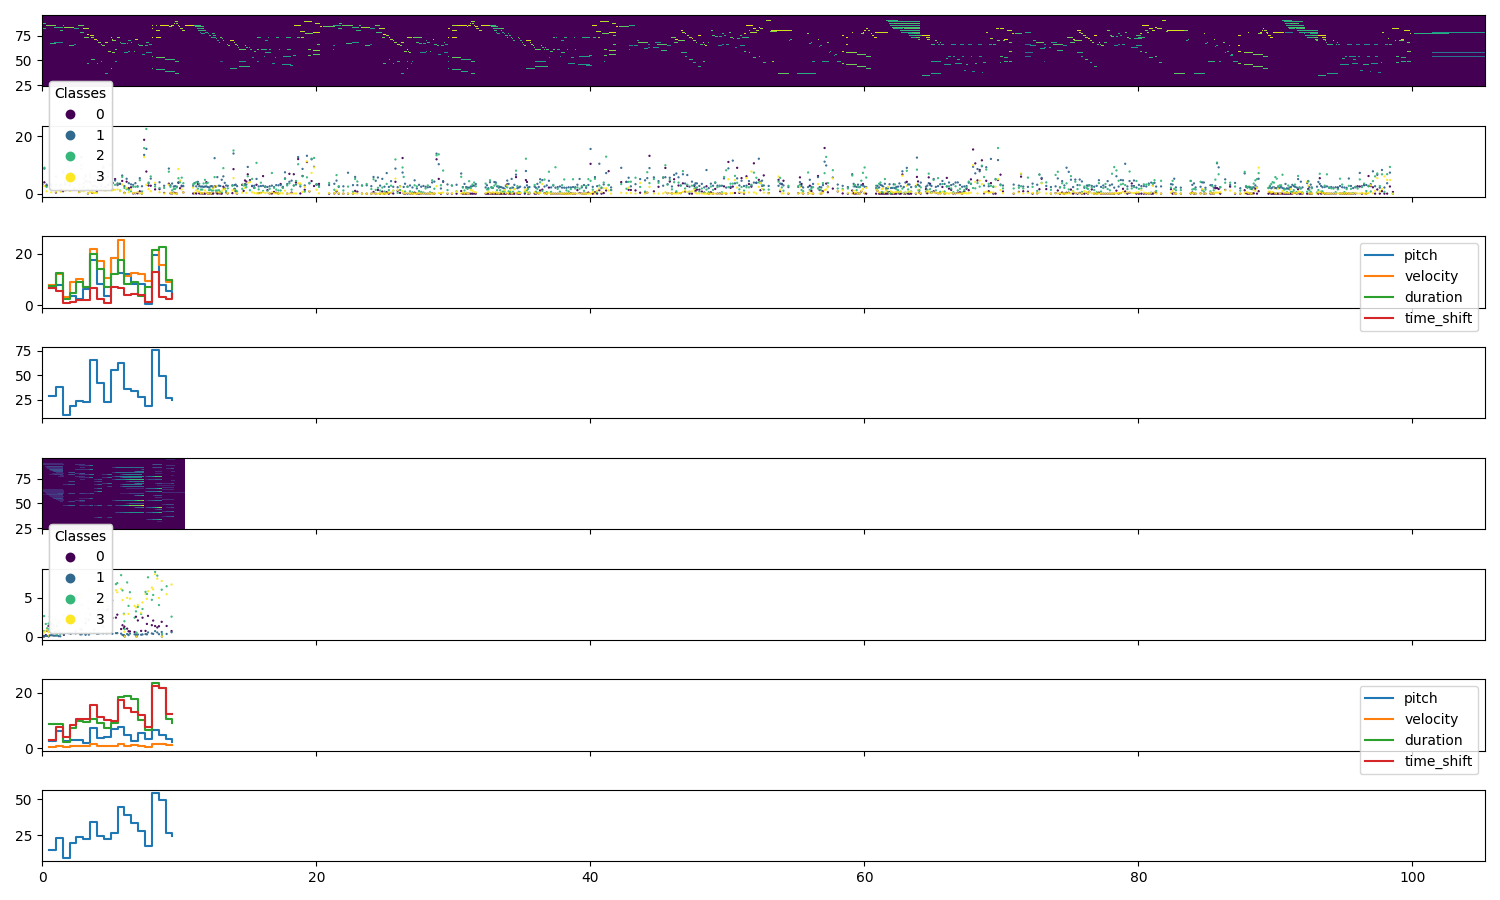

In [18]:
files = [f'/home/mathias/.cache/mutdata/pia/databases/Piano/transcriptions/midi/{piece}.mid', 'out/inpainted_seq_ics.mid']
res = [temp, gen]

figs_pr_sample = 4
fig, ax = plt.subplots(len(files) * figs_pr_sample, 1, figsize=(15,9), sharex=True)
for i, (f, r) in enumerate(zip(files, res)):
    midi2 = pretty_midi.PrettyMIDI(f)
    first_onset = min([n.start for n in  midi2.instruments[0].notes])
    for note in midi2.instruments[0].notes:
        note.start -= first_onset
        note.end -= first_onset
    delta = 1e-6
    for cc in midi2.instruments[0].control_changes:
        cc.time -= first_onset
        if cc.time < 0:
            cc.time = 0
    sr = 10
    pr2 = midi2.get_piano_roll(sr).T
    end = pr2.shape[0]/sr


    legends = dataloader_generator.features
    bs = 2

    nr = (24,96)
    # nr = (None, None)
    ax[i *figs_pr_sample + 0].imshow(pr2.T[slice(*nr)], origin='lower',extent=[0, end, *nr],aspect='auto', interpolation='none')

    channels = slice(0, 4)
    n_channels = channels.stop- channels.start
    unique_timepoints, cum_ics = DecoderEventsHandler.unique_timepoints(r.timepoints, r.ic_tok[metadata_dict['decoding_start']:r.decoding_end])
    n_points = len(unique_timepoints)
    # ax[1].plot(unique_timepoint, cum_ics[:, channel],'.-')
    c = np.broadcast_to(np.arange(n_channels)[None,:], (n_points, n_channels)).flatten()

    times = np.broadcast_to(np.array(unique_timepoints)[:,None], (n_points, n_channels)).flatten()
    scatter = ax[i*figs_pr_sample+1].scatter(
        times,
        cum_ics[:, channels].numpy().flatten(),
        c=c,
        s=1.5,
        marker='.'
    )
    legend1 = ax[i*figs_pr_sample+1].legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax[i*figs_pr_sample+1].add_artist(legend1)

    # produce a legend with a cross-section of sizes from the scatter
    # handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    # legend2 = ax[1].legend(handles, labels, loc="upper right", title="Sizes")


    ax[i*figs_pr_sample+2].step(ts, r.ic_int[:, channels], where='post')
    ax[i*figs_pr_sample+2].legend(legends[channels])

    ax[i*figs_pr_sample+3].step(ts, r.ic_int[:, channels].sum(1), where='post')
    
    fig.tight_layout()

In [19]:
plt.savefig('out/ic_curve.pdf')